# Visualize Differences Across Cell Lines

**Gregory Way, 2019**

Visualize mean square error per feature for each cell line independently.

Also shown are F statistics, which calculates the ratio of between group variance / within group variance.

Therefore, we can interpret high F statistic values as cell health features with large differences in performance across cell lines while low values indicate features that are consistent across cell lines.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
set.seed(123)

In [3]:
get_f_stat <- function(df) {
    feature <- c()
    all_f_stat <- c()
    for (health_feature in colnames(df)) {
        if (health_feature != "Metadata_cell_line") {
            result <- eval(
                parse(
                    text = paste0("aov(", health_feature, " ~ Metadata_cell_line, data = df)")
                )
            )
            result <- summary(result)
            f_stat <- result[[1]]$`Pr(>F)`[1]
            all_f_stat <- c(all_f_stat, f_stat)
            feature <- c(feature, health_feature)
        }
    }
    
    f_stat_df <- cbind(feature, all_f_stat) %>% dplyr::as_tibble()
    return(f_stat_df)
}

## Load Reconstruction Errors

In [4]:
file <- file.path("results", "all_model_sample_squared_error.tsv")
all_score_error <- readr::read_tsv(file, col_types = readr::cols()) %>%
    dplyr::mutate(data_type = "real")

print(dim(all_score_error))
head(all_score_error, 2)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

[1] 357  75


Metadata_profile_id,Metadata_gene_name,Metadata_pert_name,Metadata_cell_line,cc_all_high_n_spots_h2ax_mean,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_mean,cc_all_n_spots_per_nucleus_area_mean,⋯,vb_percent_all_apoptosis,vb_percent_all_early_apoptosis,vb_percent_all_late_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_live,vb_ros_back_mean,vb_ros_mean,data_type
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
profile_0,AKT1,AKT1-1,A549,0.01827482,0.0201486,0.005744211,0.08761182,0.0127345,0.005873116,⋯,0.003909887,0.0128946951,0.002955232,0.03583013,0.060682336,0.04301851,0.061186524,0.1554403,0.3067447,real
profile_1,AKT1,AKT1-2,A549,0.01968005,0.8621799,0.126811496,0.06785021,0.1103038,0.236786771,⋯,0.097256071,0.0003685066,0.222655748,0.30354361,0.001590032,0.02891964,0.001573607,0.1126697,0.3966966,real


In [5]:
anova_ready_df <- all_score_error %>%
    dplyr::select(-Metadata_profile_id, -Metadata_gene_name, -Metadata_pert_name, -data_type)

f_stat_df <- get_f_stat(anova_ready_df) %>%
    dplyr::mutate(data_type = "real")
head(f_stat_df, 2)

feature,all_f_stat,data_type
<chr>,<chr>,<chr>
cc_all_high_n_spots_h2ax_mean,0.280515086929778,real
cc_all_large_notround_polynuclear_mean,0.893173091086215,real


In [6]:
file <- file.path("results", "all_model_sample_squared_error_shuffled.tsv")
all_shuffle_score_error <- readr::read_tsv(file, col_types = readr::cols()) %>%
    dplyr::mutate(data_type = "shuffled")

print(dim(all_shuffle_score_error))
head(all_shuffle_score_error, 2)

[1] 357  75


Metadata_profile_id,Metadata_gene_name,Metadata_pert_name,Metadata_cell_line,cc_all_high_n_spots_h2ax_mean,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_mean,cc_all_n_spots_per_nucleus_area_mean,⋯,vb_percent_all_apoptosis,vb_percent_all_early_apoptosis,vb_percent_all_late_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_live,vb_ros_back_mean,vb_ros_mean,data_type
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
profile_0,AKT1,AKT1-1,A549,0.05346540,0.08197296,0.025899680,0.2630316,0.0009356624,0.003891491,⋯,0.04217244,0.0128946951,0.03772921,0.03135017,0.07531607,0.140921279,0.13241752,0.7100811,1.488563,shuffled
profile_1,AKT1,AKT1-2,A549,0.03452971,1.04565450,0.003577612,0.4587953,0.0027610743,0.024156157,⋯,0.01160201,0.0003685066,0.07441263,0.31729631,0.02620061,0.003850956,0.01718552,0.3525205,1.161977,shuffled


In [7]:
anova_ready_shuffle_df <- all_shuffle_score_error %>%
    dplyr::select(-Metadata_profile_id, -Metadata_gene_name, -Metadata_pert_name, -data_type)

f_stat_shuffle_df <- get_f_stat(anova_ready_shuffle_df) %>%
    dplyr::mutate(data_type = "shuffled")
head(f_stat_shuffle_df, 2)

feature,all_f_stat,data_type
<chr>,<chr>,<chr>
cc_all_high_n_spots_h2ax_mean,0.797465589245849,shuffled
cc_all_large_notround_polynuclear_mean,0.44894644401521,shuffled


## Process Data for Visualization

In [8]:
# Merge Data
full_score_error <- all_score_error %>% 
    dplyr::bind_rows(all_shuffle_score_error)

full_fstat <- f_stat_df %>% 
    dplyr::bind_rows(f_stat_shuffle_df)

mse_mean_cell_line_df <- full_score_error %>%
    dplyr::group_by(Metadata_cell_line, data_type) %>%
    dplyr::summarise_at(vars(starts_with("cc"), starts_with("vb")), mean, na.rm = TRUE) %>%
    reshape2::melt(id.vars = c("Metadata_cell_line", "data_type"),
                   variable.name = "feature",
                   value.name = "mse_mean") %>%
    dplyr::inner_join(full_fstat, by = c("feature", "data_type")) %>%
    dplyr::arrange(desc(mse_mean))

mse_mean_cell_line_df$all_f_stat <- as.numeric(paste(mse_mean_cell_line_df$all_f_stat))
mse_mean_cell_line_df$data_type <- factor(mse_mean_cell_line_df$data_type, levels = c("shuffled", "real"))

head(mse_mean_cell_line_df, 10)

Warning message:
“`is_lang()` is deprecated as of rlang 0.2.0.
Please use `is_call()` instead.
This warning is displayed once per session.”Warning message:
“`lang()` is deprecated as of rlang 0.2.0.
Please use `call2()` instead.
This warning is displayed once per session.”Warning message:
“`mut_node_car()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”Warning message:
“Column `feature` joining factor and character vector, coercing into character vector”

Metadata_cell_line,data_type,feature,mse_mean,all_f_stat
<chr>,<fct>,<chr>,<dbl>,<dbl>
A549,real,cc_mitosis_ph3_neg_high_n_spots_h2ax_mean,2.557096,0.40363189
A549,shuffled,cc_mitosis_ph3_neg_high_n_spots_h2ax_mean,2.557096,0.40363189
ES2,shuffled,cc_g1_plus_g2,1.507659,0.08661265
ES2,shuffled,cc_all_nucleus_roundness_mean,1.355524,0.28730136
ES2,shuffled,vb_percent_all_late_apoptosis,1.342575,0.26639548
ES2,shuffled,cc_cc_ph3_pos_hoechst_mitosis_mean,1.342555,0.48600690
ES2,shuffled,vb_ros_mean,1.284880,0.45545737
ES2,shuffled,vb_percent_dead,1.278107,0.29511543
ES2,shuffled,vb_percent_live,1.242887,0.37178134


## Visualize

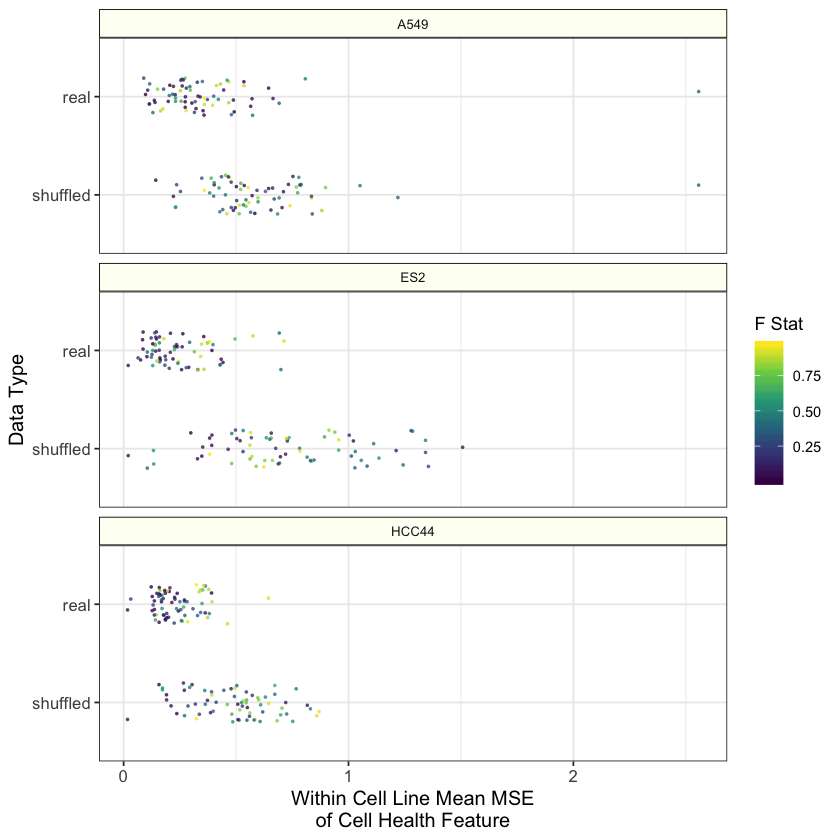

In [9]:
ggplot(mse_mean_cell_line_df,
       aes(x = data_type,
           y = mse_mean,
           color = all_f_stat)) +
    geom_jitter(width = 0.2, size = 0.7, alpha = 0.8, pch = 16) +
    facet_wrap(~Metadata_cell_line, nrow = 3) +
    scale_color_viridis_c(name = "F Stat") +
    xlab("Data Type") +
    ylab("Within Cell Line Mean MSE\nof Cell Health Feature") +
    coord_flip() +
    theme_bw() +
    theme(
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 12),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path("figures", "cell_line_mse_differences.png")
ggsave(output_file, height = 5, width = 5, dpi = 500)